In [10]:
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    Flatten,
    Input
)
from tensorflow.keras import Model
import pandas as pd
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import cv2


In [11]:
path = Path('data')
X_train = np.load(path/'X_train.npy')
y_train = np.load(path/'y_train.npy')
X_test = np.load(path/'X_test.npy')
test_images = np.load(path/'X_test.npy') 
y_test = np.load(path/'y_test.npy')
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((366, 32, 32, 3), (366, 5), (92, 32, 32, 3), (92, 5))

In [12]:
test_images.shape

(92, 32, 32, 3)

In [13]:
EPOCHS = 50
BATCH_SIZE = 32
IMG_SIZE = X_train.shape[1]
X_test.shape

(92, 32, 32, 3)

In [14]:
def filter_grey(X:np.ndarray):
    new_x = []
    for i in range(len(X)):
        img = X[i]
        # np array to cv2 imag        
        # grey scale
        #result = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        result = img / 255
        new_x.append(result)
    return np.array(new_x)

X_train = filter_grey(X_train)
X_test = filter_grey(X_test)




[0.28515625 0.1875     0.26171875 0.5234375 ]
[0.15625    0.3984375  0.22265625 0.4453125 ]
[0.69921875 0.0234375  0.22265625 0.4453125 ]
[0.07421875 0.25       0.22265625 0.4453125 ]
[0.12109375 0.02734375 0.22265625 0.4453125 ]
[0.34765625 0.37890625 0.22265625 0.4453125 ]


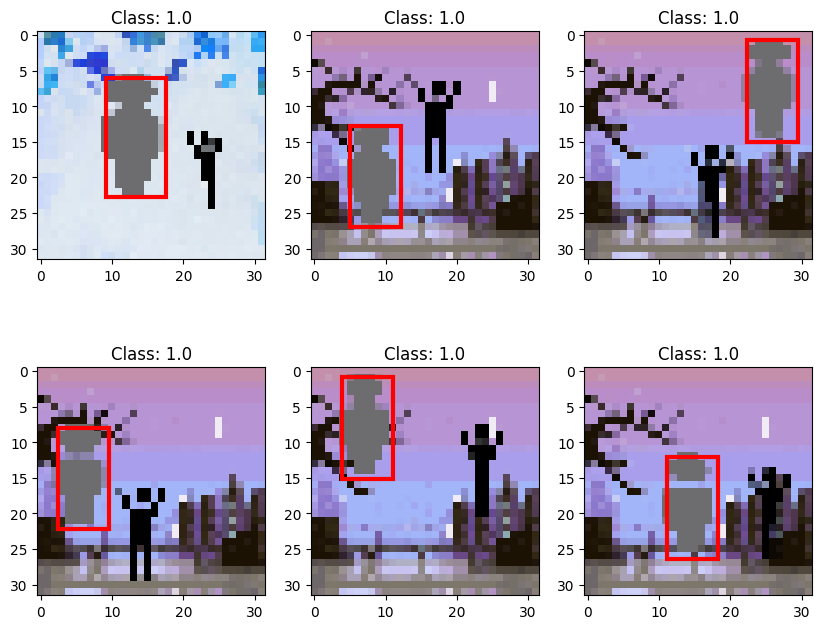

In [15]:
fig, ax = plt.subplots(2, 3, figsize=(10, 8))
images = np.random.choice(X_train.shape[0], 6)
for i in range(2):
    for j in range(3):
        rect = y_train[images[i * 3 + j]][1:]
        label = y_train[images[i * 3 + j]][0]
        print(rect)
        x, y, w, h = rect
        ax[i, j].add_patch(
            plt.Rectangle(
                (x * IMG_SIZE, y * IMG_SIZE),
                w * IMG_SIZE,
                h * IMG_SIZE,
                fill=False,
                edgecolor="red",
                lw=3,
            )
        )
        ax[i,j].set_title(f"Class: {label}")
        ax[i, j].imshow(X_train[images[i * 3 + j]], cmap="gray")

plt.show()


In [16]:
def build_model():
    # Define model layers.
    input_layer = Input(name= 'input' ,shape=(IMG_SIZE, IMG_SIZE, 3))
    first_dense = Conv2D(32, (6,6), activation='relu', name='conv1')(input_layer)
    second_dense = Conv2D(32, (6,6), activation='relu', name='conv2')(first_dense)
    flatten_layer = Flatten(name= 'flatten' )(second_dense)
    third_dense = Dense(units=8,activation='relu', name='relu1')(flatten_layer)
    y1_output = Dense(units=1, name='classification')(third_dense)
    y2_output = Dense(units=4,name='regression',activation='relu')(third_dense)
    model = Model(inputs=input_layer,outputs=[y1_output, y2_output])
    return model



In [17]:
model = build_model()
optimizer = Adam()
model.compile(optimizer=optimizer, loss={'classification': 'binary_crossentropy', 'regression': 'mse'})
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1 (Conv2D)                 (None, 27, 27, 32)   3488        ['input[0][0]']                  
                                                                                                  
 conv2 (Conv2D)                 (None, 22, 22, 32)   36896       ['conv1[0][0]']                  
                                                                                                  
 flatten (Flatten)              (None, 15488)        0           ['conv2[0][0]']                  
                                                                                            

In [36]:
# history = model.fit(X_train, y_train[:,1:], epochs=EPOCHS, batch_size=BATCH_SIZE)
# history = model.fit(X_train, {'classification': y_train[:,0], 'regression': y_train[:,1:]}, epochs=EPOCHS, batch_size=BATCH_SIZE)
# fit and use smallest loss for prediction
history = model.fit(
    X_train,
    {"classification": y_train[:, 0], "regression": y_train[:, 1:]},
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(
        X_test,
        {"classification": y_test[:, 0], "regression": y_test[:, 1:]},
    ),
    # callbacks=[
    #     tf.keras.callbacks.EarlyStopping(
    #         monitor="val_loss", patience=10, restore_best_weights=True)]
)


Epoch 1/50
12/12 [==============================] - 2s 136ms/step - loss: 0.0420 - classification_loss: 0.0000e+00 - regression_loss: 0.0420 - val_loss: 0.0663 - val_classification_loss: 0.0267 - val_regression_loss: 0.0396
Epoch 2/50
12/12 [==============================] - 1s 119ms/step - loss: 0.0416 - classification_loss: 0.0000e+00 - regression_loss: 0.0416 - val_loss: 0.0711 - val_classification_loss: 0.0317 - val_regression_loss: 0.0394
Epoch 3/50
12/12 [==============================] - 1s 115ms/step - loss: 0.0414 - classification_loss: 0.0000e+00 - regression_loss: 0.0414 - val_loss: 0.0626 - val_classification_loss: 0.0234 - val_regression_loss: 0.0392
Epoch 4/50
12/12 [==============================] - 1s 109ms/step - loss: 0.0452 - classification_loss: 0.0020 - regression_loss: 0.0432 - val_loss: 0.0480 - val_classification_loss: 7.9298e-04 - val_regression_loss: 0.0472
Epoch 5/50
12/12 [==============================] - 1s 104ms/step - loss: 0.0480 - classification_loss: 

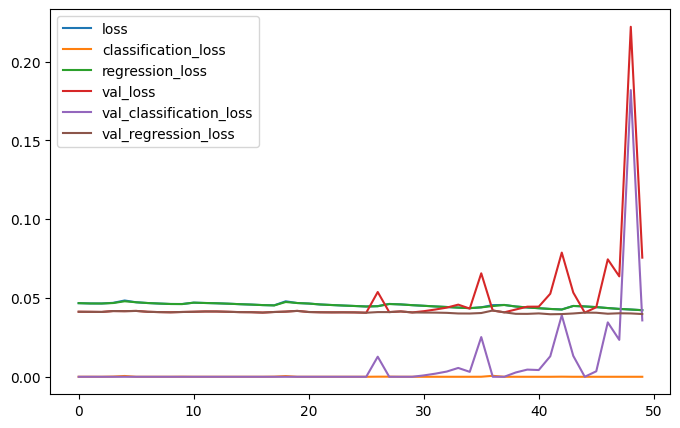

In [33]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
# save model
model.save('model_without_filters.h5')

In [34]:
# sample predict
pred = model.predict(X_test[:1])
pred[0].shape, pred[1].shape

1/1 [==============================] - 0s 48ms/step


((1, 1), (1, 4))

[0.06062671 0.         0.         0.13788946]
[0.31263998 0.         0.         0.39939576]
[0.28433475 0.         0.         0.3700243 ]
[0.34596735 0.         0.         0.4339785 ]
[0.4258315 0.        0.        0.516851 ]
[0.2856469  0.         0.         0.37138584]


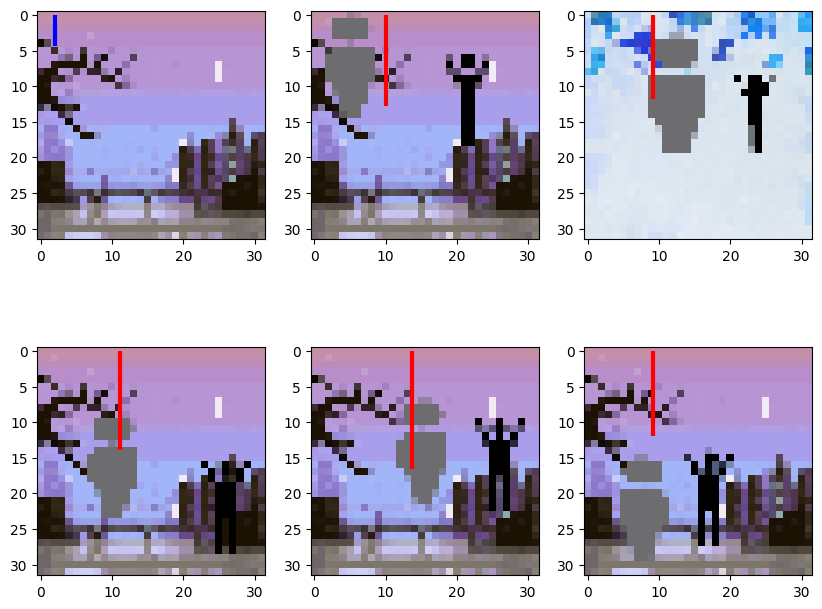

In [35]:
fig, ax = plt.subplots(2, 3, figsize=(10, 8))
imgs = np.random.choice(X_test.shape[0], 6)
for i in range(2):
    for j in range(3):
        index = np.random.randint(0, X_test.shape[0])
        rect = model.predict(X_test[index:index+1], verbose=0)[1][0]
        classification = model.predict(X_test[index:index+1], verbose=0)[0][0]
        print(rect)
        x, y, w, h = rect
        color = 'red' if classification > 0.5 else 'blue'
        ax[i, j].add_patch(
            plt.Rectangle(
                (x * IMG_SIZE, y * IMG_SIZE),
                w * IMG_SIZE,
                h * IMG_SIZE,
                fill=False,
                edgecolor=color,
                lw=3,
            )
            )
        # draw true rect 
        
        ax[i, j].imshow(test_images[index]/ 255)
plt.show()
